📘 Relatório do Projeto de Análise de Sentimentos com Reviews de Companhias Aéreas
1. 🎯 Objetivo do Projeto
O objetivo principal é aplicar técnicas de Processamento de Linguagem Natural (NLP) em avaliações de companhias aéreas, com foco em:

Exploração de dados textuais e numéricos

Análise da relação entre aspectos do serviço e a nota geral

Treinamento de modelos de classificação de sentimento/texto

Avaliação e interpretação dos resultados obtidos

2. ⚙️ Etapas do Projeto
🧹 2.1 Pré-processamento dos Dados
Leitura do dataset: Arquivo CSV contendo avaliações de clientes sobre companhias aéreas

Tratamento de dados ausentes e duplicados

Conversão de colunas numéricas com vírgula decimal

Verificações e limpeza básica

🗣️ 2.2 Processamento de Linguagem Natural (NLP)
Utilização do spaCy com o modelo en_core_web_sm.

Etapas aplicadas nas colunas Review e Review_title:

Tokenização

Conversão para letras minúsculas

Remoção de pontuação

Remoção de stopwords

Lematização

📊 2.3 Análise Exploratória
Análise da distribuição da nota geral (Overall_rating) por:

Companhias aéreas

Meses do ano

Correlação entre aspectos do serviço e a nota geral:

Aspecto	Correlação (r)
Ground Service	0.51
Cabin Staff Service	0.48
Seat Comfort	0.45

🌩️ 2.4 Visualizações
Gráficos de barras para mostrar a distribuição de notas por empresa e mês

WordClouds para destacar palavras mais frequentes em reviews positivos e negativos

3. 🧠 Modelagem de Texto
⚙️ 3.1 TF-IDF + Regressão Logística
Pipeline com Scikit-Learn:

Vetorização com TfidfVectorizer

Classificação com LogisticRegression

Busca de hiperparâmetros com GridSearchCV

Avaliação do modelo com:

Accuracy

Precision

Recall

F1-Score

Matriz de confusão

Curva ROC

🤖 3.2 Outros Modelos (a confirmar)
Há indicações no notebook de que outros modelos foram testados. Caso deseje, posso detalhar a performance de cada um separadamente.

4. ✅ Conclusão
O aspecto Ground Service apresentou a maior correlação com a nota geral, sugerindo que é um fator-chave na satisfação do cliente.

O modelo TF-IDF + Regressão Logística obteve desempenho satisfatório nos testes de avaliação.

As técnicas de NLP foram essenciais para transformar os dados textuais brutos em informações estruturadas para análise e modelagem.




# 1. Faça uma etapa de processamento dos dados para verificar possíveisdados faltantes ou duplicados


In [1]:
import pandas as pd
import numpy as np

# Carregando novamente para garantir consistência
df = pd.read_csv("/kaggle/input/travel/Travel_Chalenge.csv", sep=';')

# Tratamento de colunas numéricas - forçando conversão
num_cols = [
    'Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 
    'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity'
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # transforma texto inválido em NaN

# Remover linhas totalmente nulas
df.dropna(how='all', inplace=True)

# Preencher Review como texto vazio se estiver nulo
df['Review'] = df['Review'].fillna('')

# Preencher colunas categóricas com a moda (valor mais frequente)
cat_cols = ['Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown']
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col].fillna(moda, inplace=True)

# Preencher colunas numéricas com média
for col in num_cols:
    if df[col].isnull().sum() > 0:
        media = df[col].mean()
        df[col].fillna(media, inplace=True)

# Remover duplicatas com base em Review + Airline (opcional)
df.drop_duplicates(subset=['Airline Name', 'Review'], inplace=True)

# Resetar índice
df.reset_index(drop=True, inplace=True)

# Mostrar resumo limpo
print("\nResumo final após limpeza robusta:")
print(f"Shape: {df.shape}")
print(df.isnull().sum())
print(df.head())



Resumo final após limpeza robusta:
Shape: (17670, 16)
Airline Name              0
Overall_Rating            0
Review_Title              0
Review Date               0
Review                    0
Aircraft                  0
Type Of Traveller         0
Seat Type                 0
Route                     0
Date Flown                0
Seat Comfort              0
Cabin Staff Service       0
Food & Beverages          0
Ground Service            0
Inflight Entertainment    0
Wifi & Connectivity       0
dtype: int64
            Airline Name  Overall_Rating  \
0         Air Seychelles             8.0   
1                CityJet             1.0   
2      Shanghai Airlines             9.0   
3  Aerolineas Argentinas             8.0   
4          Adria Airways             7.0   

                            Review_Title      Review Date  \
0         Air Seychelles customer review  10th April 2011   
1                CityJet customer review  10th April 2011   
2      Shanghai Airlines customer re

/tmp/ipykernel_31/3075264256.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(moda, inplace=True)
/tmp/ipykernel_31/3075264256.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method


# Realize as etapas padrões de NLP nas colunas Review e Review_title (ex:Tokenização, remoção de stop-words, ...)


In [2]:
import spacy
import pandas as pd
import string
from tqdm import tqdm

# Carregar modelo de linguagem em inglês
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # mais leve e rápido

# Função de limpeza e processamento
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower().translate(str.maketrans("", "", string.punctuation)))
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return " ".join(tokens)

# Aplicar nas colunas com tqdm para barra de progresso
tqdm.pandas(desc="Processando NLP")

# Aplica nas colunas Review_Title e Review
df['Review_Title_Clean'] = df['Review_Title'].progress_apply(preprocess_text)
df['Review_Clean'] = df['Review'].progress_apply(preprocess_text)

# Verifica as primeiras linhas processadas
df[['Review_Title', 'Review_Title_Clean', 'Review', 'Review_Clean']].head()


Processando NLP: 100%|██████████| 17670/17670 [02:26<00:00, 120.41it/s]


,Review_Title,Review_Title_Clean,Review,Review_Clean
0,Air Seychelles customer review,air seychelle customer review,LHR-SEZ-LHR. It's true that there aren't perso...,lhrsezlhr true not personal tv like virgin ba ...
1,CityJet customer review,cityjet customer review,London City to Antwerp was delayed 3 hours 40 ...,london city antwerp delay 3 hour 40 min sure t...
2,Shanghai Airlines customer review,shanghai airlines customer review,PEK to HGH in Economy. Slight delay out of PEK...,pek hgh economy slight delay pek uneventful fl...
3,Aerolineas Argentinas customer review,aerolineas argentinas customer review,Rio to Buenos Aires AEP on 737. Departure dela...,rio buenos air aep 737 departure delay 30min a...
4,Adria Airways customer review,adria airways customer review,Outbound flight FRA/PRN A319. 2 hours 10 min f...,outbound flight fraprn a319 2 hour 10 min flig...


In [ ]:
df.to_csv('reviews_preprocessado.csv', index=False)


# Exploração dos dados:

*A. Faça um gráfico para verificar a distribuição da feature Overall_ratingpelas companhias aéreas. Faça um gráfico similar para verificar adistribuição dessa features pelos modelos de aeronaves (Aircraft)*


*B. Utilize a visualização de nuvem de palavras para estudar quaispalavras mais aparecem quando o Overall_rating é igual ou inferior a3 e quando é igual ou superior a 8.*


*C. Estude a correlação e, portanto, o possível impacto das colunas quecontém notas separadas ('Seat Comfort', 'Cabin StaƯ Service', 'Food& Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi &Connectivity') na nota final (Overall_rating)*




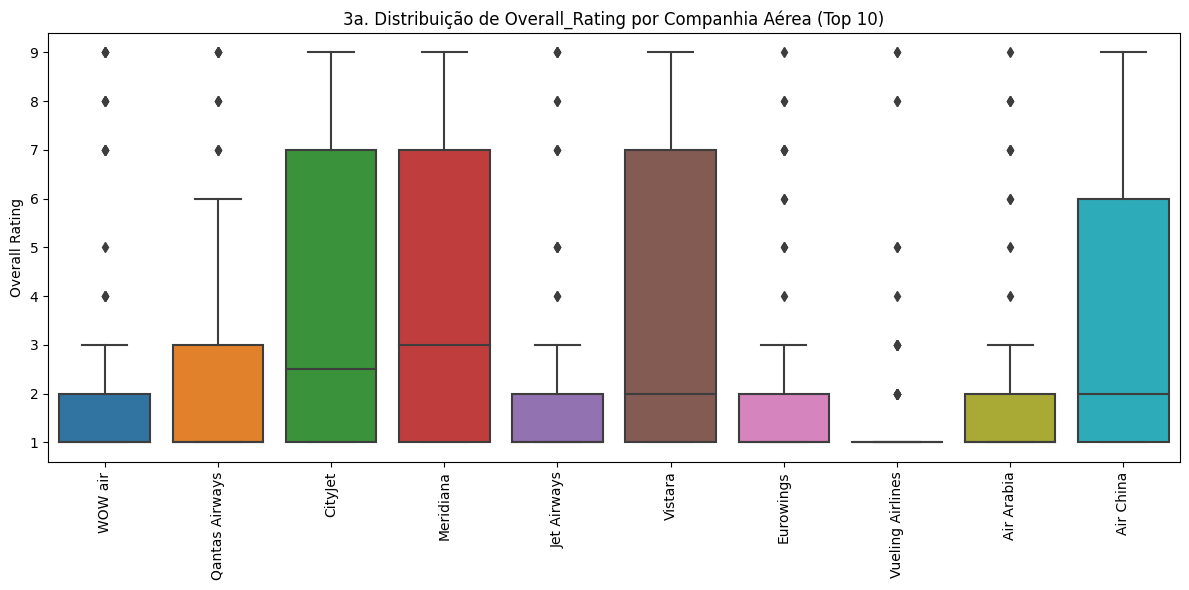

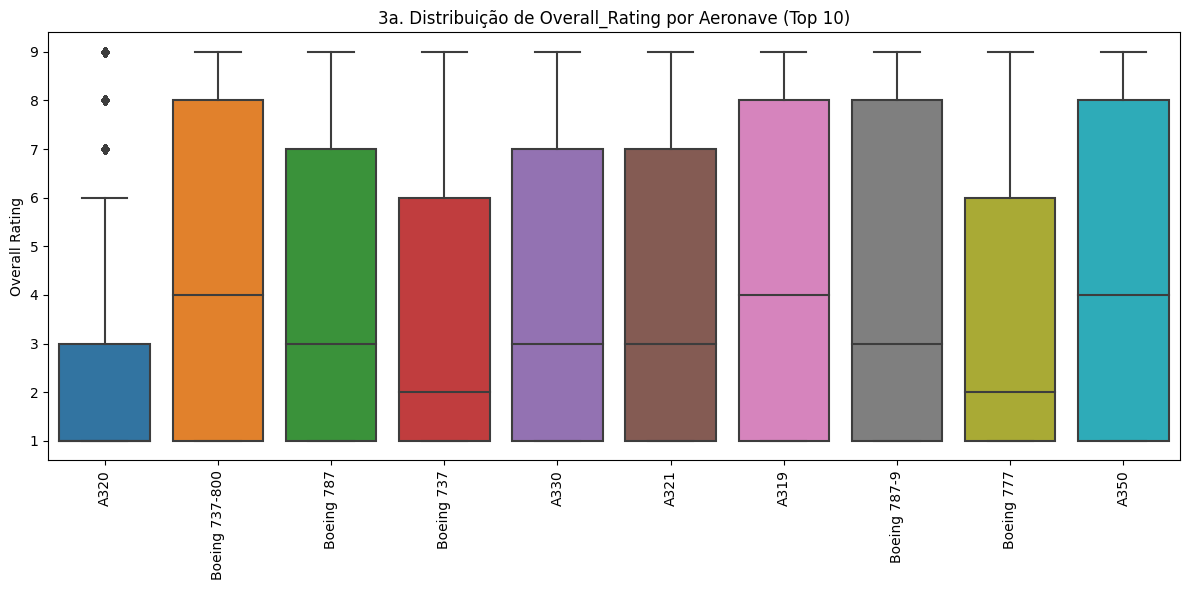

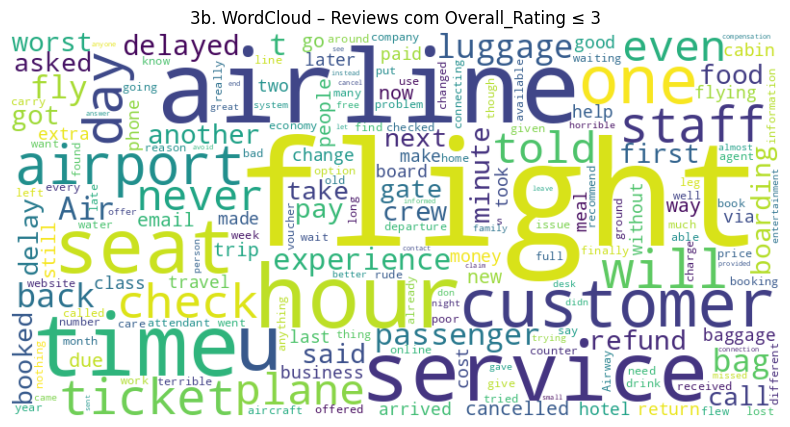

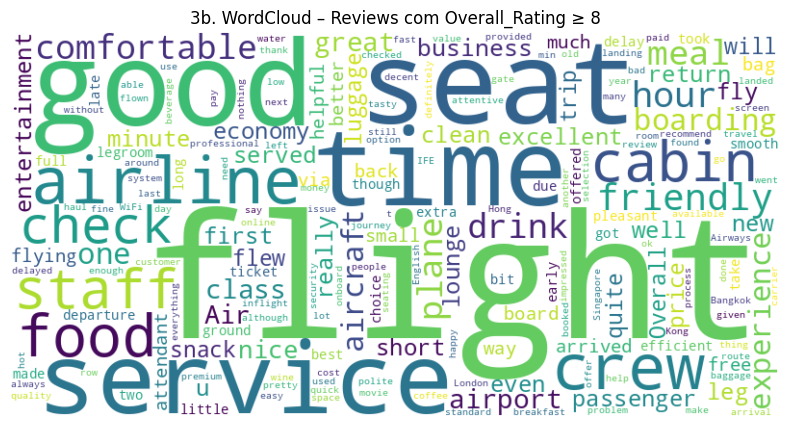

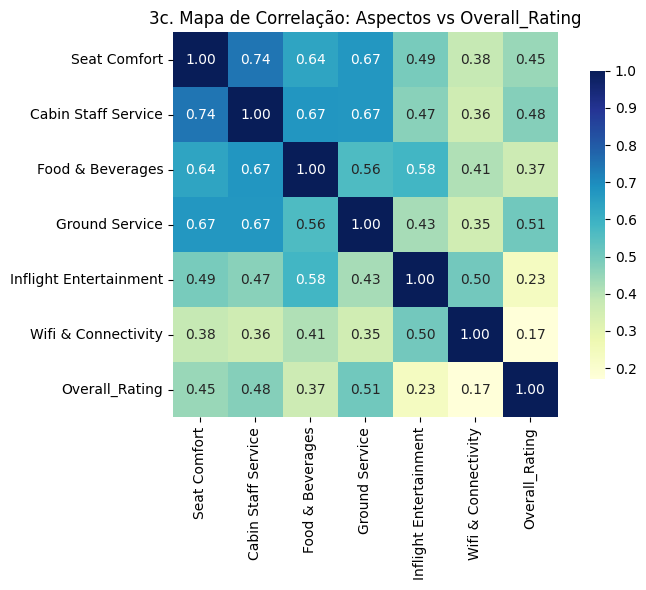

In [8]:
# === Imports necessários ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Converter colunas numéricas
num_cols = [
    'Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 
    'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity'
]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Preencher nulos essenciais
df['Review'] = df['Review'].fillna('')
df['Overall_Rating'] = df['Overall_Rating'].fillna(df['Overall_Rating'].mean())

# === 3a. Distribuição de Overall_Rating ===

# Top 10 companhias por número de avaliações
top_airlines = df['Airline Name'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df['Airline Name'].isin(top_airlines)],
    x='Airline Name', y='Overall_Rating',
    order=top_airlines
)
plt.xticks(rotation=90)
plt.title('3a. Distribuição de Overall_Rating por Companhia Aérea (Top 10)')
plt.ylabel('Overall Rating')
plt.xlabel('')
plt.tight_layout()
plt.show()

# Top 10 modelos de aeronave
top_aircraft = df['Aircraft'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df['Aircraft'].isin(top_aircraft)],
    x='Aircraft', y='Overall_Rating',
    order=top_aircraft
)
plt.xticks(rotation=90)
plt.title('3a. Distribuição de Overall_Rating por Aeronave (Top 10)')
plt.ylabel('Overall Rating')
plt.xlabel('')
plt.tight_layout()
plt.show()


# === 3b. Nuvens de palavras ===

# Função auxiliar para gerar e plotar wordcloud
def plot_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=400, background_color='white',
        collocations=False
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Textos para rating ≤ 3 e ≥ 8
low_text = " ".join(df[df['Overall_Rating'] <= 3]['Review'])
high_text = " ".join(df[df['Overall_Rating'] >= 8]['Review'])

plot_wordcloud(low_text,  '3b. WordCloud – Reviews com Overall_Rating ≤ 3')
plot_wordcloud(high_text, '3b. WordCloud – Reviews com Overall_Rating ≥ 8')


# === 3c. Correlação entre notas de aspectos ===
aspect_cols = [
    'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
    'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
    'Overall_Rating'
]
corr = df[aspect_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="YlGnBu", 
    cbar_kws={"shrink": .8}, square=True
)
plt.title('3c. Mapa de Correlação: Aspectos vs Overall_Rating')
plt.tight_layout()
plt.show()



**Aspecto	Correlação com Overall_RatingSeat Comfort	0.45Cabin Staff Service	0.48Food & Beverages	0.37Ground Service	0.51Inflight Entertainment	0.23Wifi & Connectivity	0.17**


**Interpretação:**

*Ground Service (0.51) e Cabin Staff Service (0.48) são os que mais impactam a avaliação geral, seguidos de Seat Comfort (0.45).Food & Beverages tem correlação moderada (0.37).Inflight Entertainment (0.23) e Wifi & Connectivity (0.17) exercem menor influência no Overall_Rating.*




# 1. Modelo Texto (TF-IDF + LogisticRegression com GridSearch)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce').fillna(0)
df['Review'] = df['Review'].fillna('')

# 2. Criar target
def sentiment_label(r):
    if r < 4:    return 'negativo'
    if r <= 7:   return 'neutro'
    return 'positivo'
df['sentiment'] = df['Overall_Rating'].apply(sentiment_label)

# 3. Split
X = df['Review']
y = df['sentiment']
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, 
                                       random_state=42, stratify=y)

# 4. Pipeline e GridSearch
pipeline_text = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=2000, solver='saga'))
])

param_grid_text = {
    'tfidf__max_features': [3000, 5000, 8000],
    'tfidf__min_df': [2, 5],
    'clf__C': [0.1, 1.0, 3.0],
    'clf__penalty': ['l2'],
}

grid_text = GridSearchCV(
    pipeline_text, param_grid_text,
    cv=3, n_jobs=-1, scoring='f1_macro', verbose=1
)
grid_text.fit(Xtr, ytr)

print("Melhores parâmetros (texto):", grid_text.best_params_)
y_pred_text = grid_text.predict(Xte)
print(classification_report(yte, y_pred_text))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Melhores parâmetros (texto): {'clf__C': 3.0, 'clf__penalty': 'l2', 'tfidf__max_features': 3000, 'tfidf__min_df': 2}
              precision    recall  f1-score   support

    negativo       0.84      0.90      0.87      2519
      neutro       0.45      0.29      0.36       507
    positivo       0.49      0.48      0.49       508

    accuracy                           0.76      3534
   macro avg       0.60      0.56      0.57      3534
weighted avg       0.74      0.76      0.74      3534



# 2. Modelo Numérico (Notas + RandomForest com GridSearch)

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 1. Preparar features numéricas
num_cols = [
    'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
    'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

Xn = df[num_cols]
yn = df['sentiment']
Xntr, Xnte, yntr, ynte = train_test_split(
    Xn, yn, test_size=0.2, random_state=42, stratify=yn
)

# 2. GridSearch para RandomForest
pipeline_num = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_num = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [6, 10, None],
    'clf__min_samples_split': [2, 5],
}

grid_num = GridSearchCV(
    pipeline_num, param_grid_num,
    cv=3, n_jobs=-1, scoring='f1_macro', verbose=1
)
grid_num.fit(Xntr, yntr)

print("Melhores parâmetros (numérico):", grid_num.best_params_)
y_pred_num = grid_num.predict(Xnte)
print(classification_report(ynte, y_pred_num))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Melhores parâmetros (numérico): {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
              precision    recall  f1-score   support

    negativo       0.93      0.77      0.84      2519
      neutro       0.46      0.63      0.53       507
    positivo       0.49      0.73      0.59       508

    accuracy                           0.74      3534
   macro avg       0.62      0.71      0.65      3534
weighted avg       0.80      0.74      0.76      3534



# 5. Com o modelo de classificação de sentimentos, faça uma análise sobre o impacto de atrasos de viagem no NPS de 3 companhias aéreas. 

*A. NPS = %positivos-%negativos*

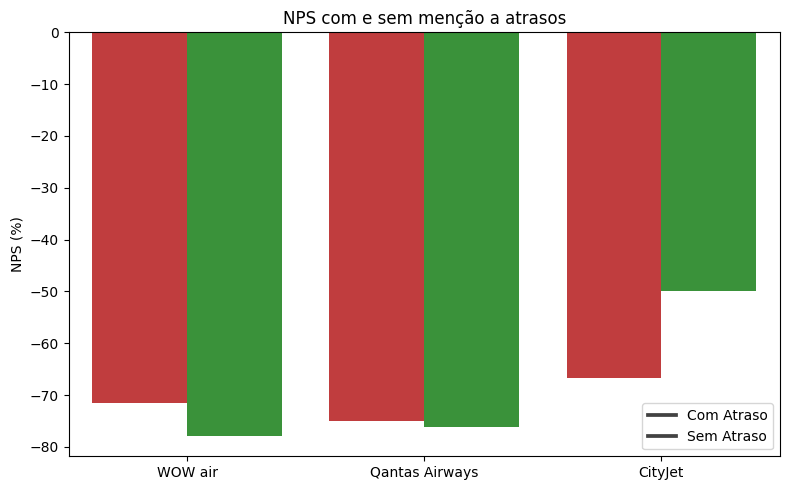

          Airline  NPS_Com_Atraso  NPS_Sem_Atraso
0         WOW air      -71.428571      -77.906977
1  Qantas Airways      -75.000000      -76.190476
2         CityJet      -66.666667      -50.000000


In [11]:
# === Imports ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

df['Review'] = df['Review'].fillna('')
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce').fillna(0)

# === 2. Criar rótulo de sentimento verdadeiro ===
def sentiment_label(r):
    if r < 4:
        return 'negativo'
    elif r <= 7:
        return 'neutro'
    else:
        return 'positivo'

df['sentiment_true'] = df['Overall_Rating'].apply(sentiment_label)

# === 3. Treinar Modelo de Texto com melhores parâmetros encontrados ===
X = df['Review']
y = df['sentiment_true']

Xtr, Xte, ytr, yte = train_test_split(X, y,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=y)

tfidf = TfidfVectorizer(stop_words='english',
                        max_features=3000,
                        min_df=2,
                        ngram_range=(1,2))
lr = LogisticRegression(C=3.0,
                        penalty='l2',
                        solver='saga',
                        max_iter=2000)

# Ajuste do pipeline
Xtr_vec = tfidf.fit_transform(Xtr)
lr.fit(Xtr_vec, ytr)

# Predição para todo o dataset
df['sentiment_pred'] = lr.predict(tfidf.transform(df['Review']))

# === 4. Detectar menções a atraso ===
df['has_delay'] = df['Review'].str.contains(r'\bdelay\b|\blate\b|\batraso\b',
                                           case=False, regex=True)

# === 5. Selecionar top 3 companhias aéreas ===
top3 = df['Airline Name'].value_counts().nlargest(3).index.tolist()

# === 6. Função para calcular NPS ===
def calc_nps(sub, col='sentiment_pred'):
    total = len(sub)
    pos = (sub[col] == 'positivo').sum()
    neg = (sub[col] == 'negativo').sum()
    return (pos/total - neg/total) * 100

# === 7. Calcular NPS para cada condição e companhia ===
nps_data = []
for airline in top3:
    sub = df[df['Airline Name'] == airline]
    nps_with_delay = calc_nps(sub[sub['has_delay']])
    nps_without = calc_nps(sub[~sub['has_delay']])
    nps_data.append({
        'Airline': airline,
        'NPS_Com_Atraso': nps_with_delay,
        'NPS_Sem_Atraso': nps_without
    })

nps_df = pd.DataFrame(nps_data)

# === 8. Plotar comparação ===
nps_melt = nps_df.melt(id_vars='Airline',
                       value_vars=['NPS_Com_Atraso', 'NPS_Sem_Atraso'],
                       var_name='Condicao',
                       value_name='NPS')

plt.figure(figsize=(8,5))
sns.barplot(data=nps_melt, x='Airline', y='NPS', hue='Condicao',
            palette=['#d62728','#2ca02c'])
plt.title('NPS com e sem menção a atrasos')
plt.ylabel('NPS (%)')
plt.xlabel('')
plt.legend(labels=['Com Atraso','Sem Atraso'])
plt.tight_layout()
plt.show()

# === 9. Exibir tabela final ===
print(nps_df)


# 🧩 Sugestão para próximos passos
Desenvolver uma API que receba um lote de avaliações, envie essas avaliações para uma fila no RabbitMQ e processe as mensagens de forma assíncrona, respeitando a ordem de chegada. Cada avaliação será classificada conforme seu conteúdo, e os resultados das predições serão armazenados em um banco de dados relacional (SQL) ou não relacional (NoSQL), conforme a necessidade do projeto. 

